## Assignment 2

In [1]:
import pandas as pd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap
from h3 import h3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_orders_path = '/data/lab/STA326_Assignment2/datasets/data_orders.csv'
data_orders = pd.read_csv(data_orders_path)

In [3]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


### Q1

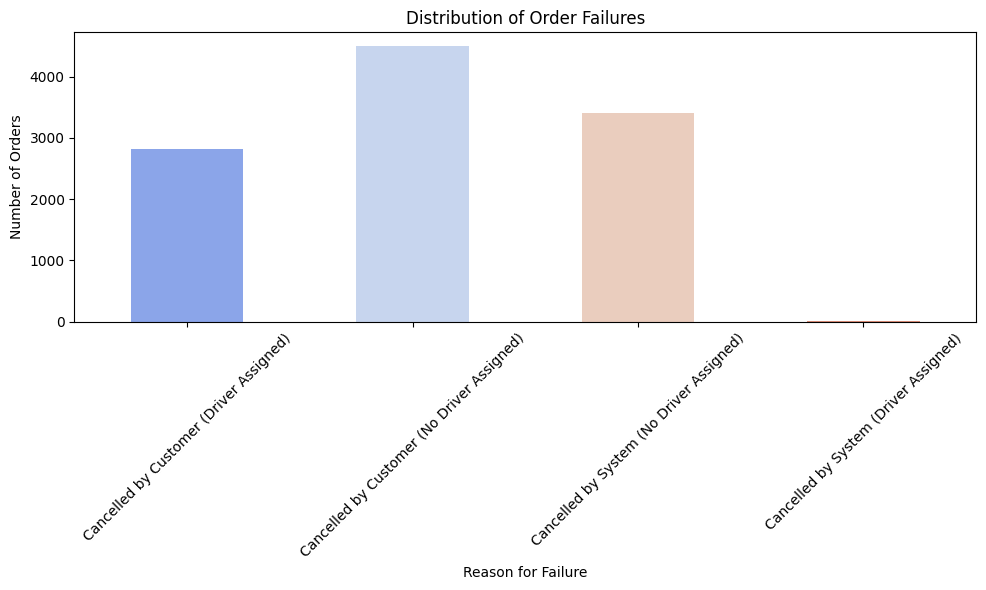

The category with the most failed orders is: Cancelled by Customer (No Driver Assigned)


In [4]:
def categorize_failure(row):
    if row['order_status_key'] == 4:
        return 'Cancelled by Customer (No Driver Assigned)' if row['is_driver_assigned_key'] == 0 else 'Cancelled by Customer (Driver Assigned)'
    elif row['order_status_key'] == 9:
        return 'Cancelled by System (No Driver Assigned)' if row['is_driver_assigned_key'] == 0 else 'Cancelled by System (Driver Assigned)'
    else:
        return 'Other'
    
data_orders['failure_category'] = data_orders.apply(categorize_failure, axis=1)

plt.figure(figsize=(10, 6))

sns.countplot(
    data=data_orders, 
    x='failure_category', 
    hue='failure_category',  
    palette='coolwarm', 
    width=0.5,
    legend=False  
)

plt.legend([],[], frameon=False)

plt.title('Distribution of Order Failures')
plt.xlabel('Reason for Failure')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

most_frequent_failure = data_orders['failure_category'].value_counts().idxmax()
print(f"The category with the most failed orders is: {most_frequent_failure}")

### Q2

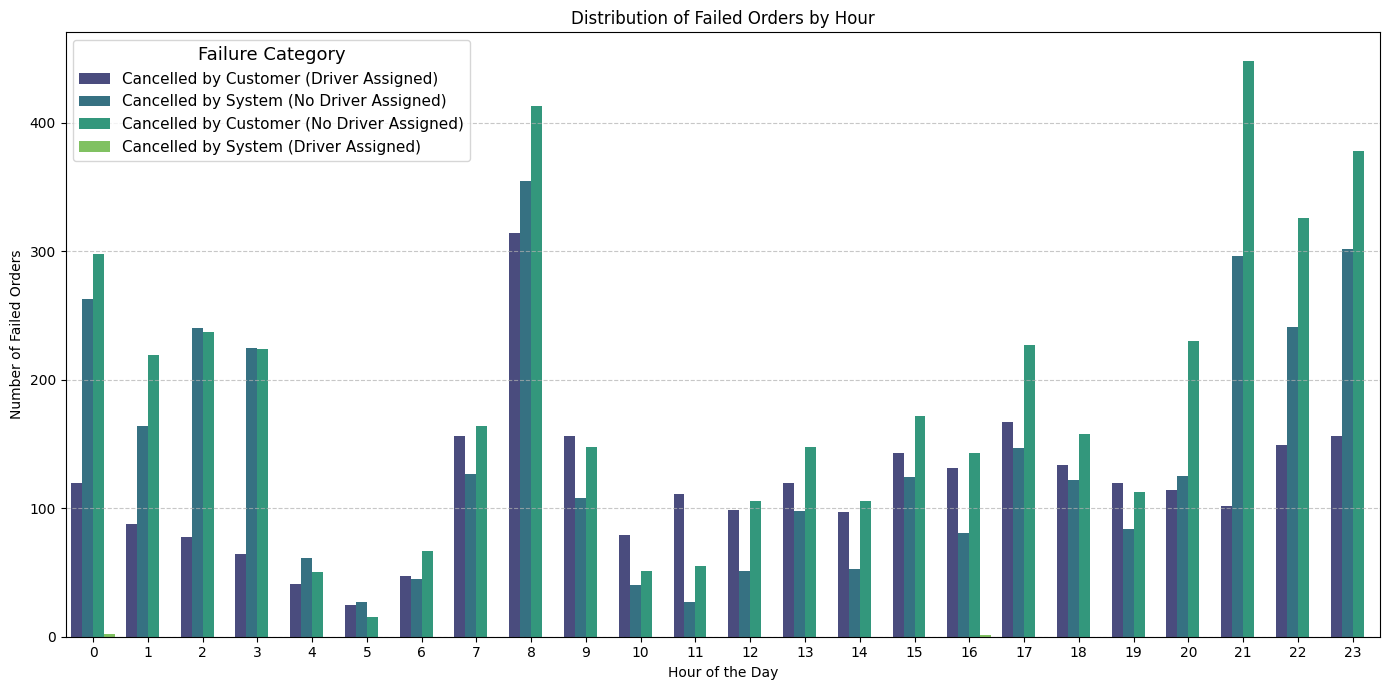

Each failure category's peak hour:
Cancelled by Customer (Driver Assigned): Most failures at 8 hour.
Cancelled by Customer (No Driver Assigned): Most failures at 21 hour.
Cancelled by System (Driver Assigned): Most failures at 0 hour.
Cancelled by System (No Driver Assigned): Most failures at 8 hour.

Overall, the hour with the most failures is: 8.


In [5]:
data_orders['order_datetime'] = pd.to_datetime(data_orders['order_datetime'])
data_orders['hour'] = data_orders['order_datetime'].dt.hour

def categorize_failure(row):
    if row['order_status_key'] == 4:
        return 'Cancelled by Customer' + (' (Driver Assigned)' if row['is_driver_assigned_key'] == 1 else ' (No Driver Assigned)')
    elif row['order_status_key'] == 9:
        return 'Cancelled by System' + (' (Driver Assigned)' if row['is_driver_assigned_key'] == 1 else ' (No Driver Assigned)')
    else:
        return 'Other'

data_orders['failure_category'] = data_orders.apply(categorize_failure, axis=1)

plt.figure(figsize=(14, 7))
sns.countplot(data=data_orders, x='hour', hue='failure_category', palette='viridis')
plt.title('Distribution of Failed Orders by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.legend(title='Failure Category', title_fontsize='13', fontsize='11')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

hourly_failure_counts = data_orders.groupby(['hour', 'failure_category']).size().unstack(fill_value=0)
max_failure_hours = hourly_failure_counts.idxmax().to_dict()
total_max_failure_hour = hourly_failure_counts.sum(axis=1).idxmax()

print("Each failure category's peak hour:")
for category, hour in max_failure_hours.items():
    print(f"{category}: Most failures at {hour} hour.")

print(f"\nOverall, the hour with the most failures is: {total_max_failure_hour}.")

#### Analysis of the result
Analyzing the provided data trends, we can observe distinct patterns in order cancellations: 'Cancelled by Customer (Driver Assigned)' peaks at 8 AM, aligning with the morning rush when customers may cancel due to delayed drivers or urgent commutes. 'Cancelled by Customer (No Driver Assigned)' surges at 9 PM, possibly when plans change post-evening activities. 'Cancelled by System (Driver Assigned)' hits a high at midnight, likely due to a shortage of drivers. 'Cancelled by System (No Driver Assigned)' also peaks at 8 AM, indicating system cancellations due to an inability to assign drivers during the morning demand spike. 

Overall, the most significant failure rate occurs at 8 AM, suggesting a critical need for strategic adjustments during the morning peak hours.

### Q3

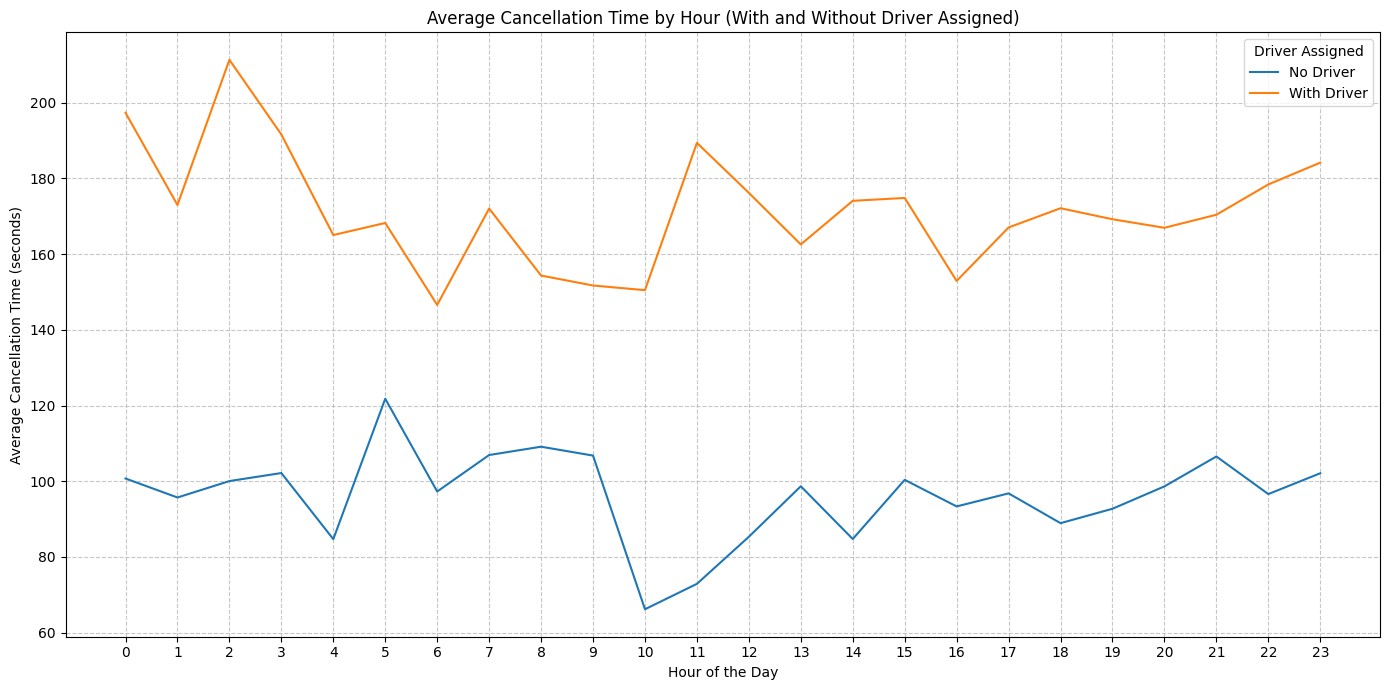

On average, orders cancelled with a driver assigned take longer than those without a driver.


In [6]:
cancelled_orders = data_orders[data_orders['order_status_key'].isin([4, 9])]

# 通过IQR方法来分析数据中的异常值
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

data_orders['hour'] = pd.to_datetime(data_orders['order_datetime']).dt.hour
cancelled_orders = data_orders[data_orders['order_status_key'].isin([4, 9])]

filtered_orders_no_driver = remove_outliers(
    cancelled_orders[cancelled_orders['is_driver_assigned_key'] == 0],
    'cancellations_time_in_seconds'
)
filtered_orders_with_driver = remove_outliers(
    cancelled_orders[cancelled_orders['is_driver_assigned_key'] == 1],
    'cancellations_time_in_seconds'
)

average_cancellation_time_no_driver = filtered_orders_no_driver.groupby('hour')['cancellations_time_in_seconds'].mean()
average_cancellation_time_with_driver = filtered_orders_with_driver.groupby('hour')['cancellations_time_in_seconds'].mean()

plt.figure(figsize=(14, 7))
sns.lineplot(data=average_cancellation_time_no_driver, label='No Driver')
sns.lineplot(data=average_cancellation_time_with_driver, label='With Driver')
plt.title('Average Cancellation Time by Hour (With and Without Driver Assigned)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Cancellation Time (seconds)')
plt.xticks(range(24))
plt.legend(title='Driver Assigned')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

if average_cancellation_time_no_driver.mean() > average_cancellation_time_with_driver.mean():
    print("On average, orders cancelled without a driver assigned take longer than those with a driver.")
else:
    print("On average, orders cancelled with a driver assigned take longer than those without a driver.")

### Q4

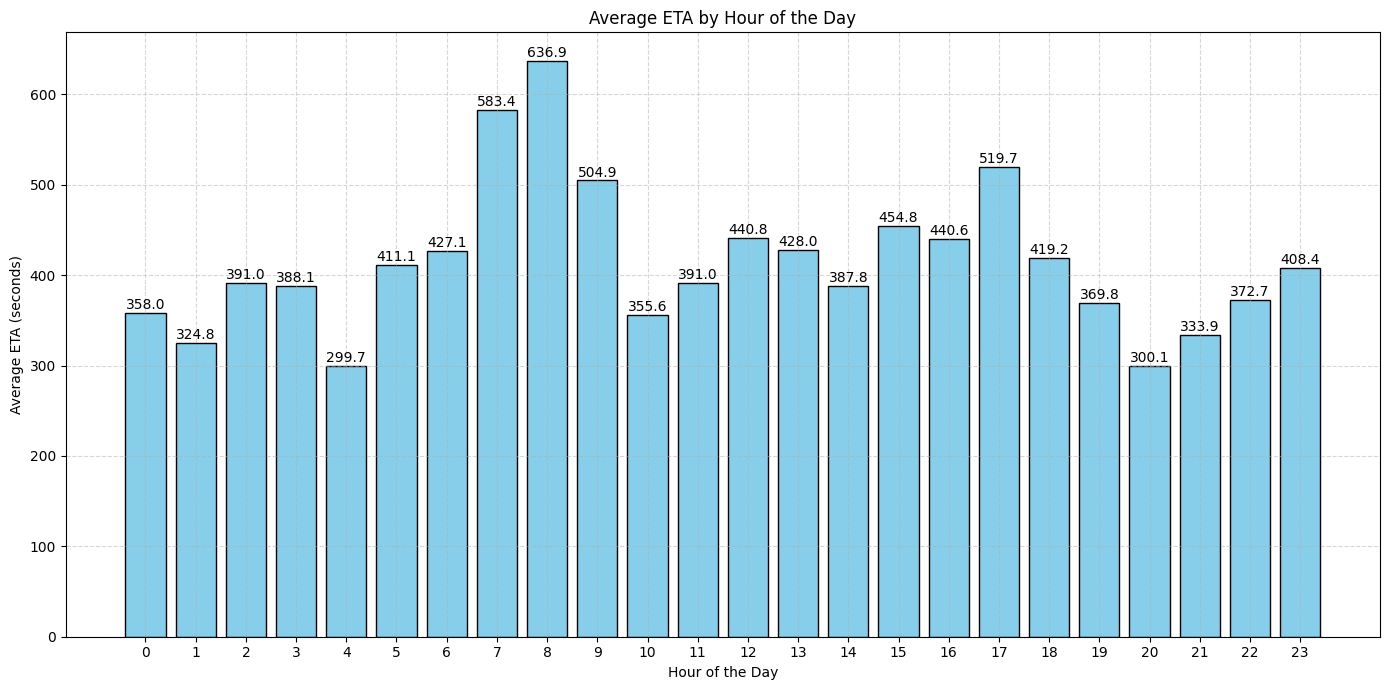

In [7]:
average_eta_by_hour = data_orders.groupby('hour')['m_order_eta'].mean()

plt.figure(figsize=(14, 7))
bars = plt.bar(average_eta_by_hour.index, average_eta_by_hour.values, color='skyblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 1), ha='center', va='bottom')

plt.title('Average ETA by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (seconds)')
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

By the plot, the tow peak happens at morning peak and evening peak when great traffic jam occurs. Thus it always takes lots of time before order arrive

### Q5

In [8]:
import pandas as pd
import folium
from h3 import h3
import branca.colormap as cm

data_orders_path = '/data/lab/STA326_Assignment2/datasets/data_orders.csv'
data_orders = pd.read_csv(data_orders_path)

data_orders['h3_index'] = data_orders.apply(
    lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1
)

h3_counts = data_orders['h3_index'].value_counts().reset_index()
h3_counts.columns = ['h3_index', 'order_count']

h3_counts.sort_values('order_count', ascending=False, inplace=True)

total_orders = h3_counts['order_count'].sum()
eighty_percent_threshold = total_orders * 0.8
cumulative_orders = 0
h3_indices_80_percent = []

for index, row in h3_counts.iterrows():
    cumulative_orders += row['order_count']
    h3_indices_80_percent.append(row['h3_index'])
    if cumulative_orders >= eighty_percent_threshold:
        break

h3_indices_80_percent_df = h3_counts[h3_counts['h3_index'].isin(h3_indices_80_percent)]

color_scale = cm.linear.YlOrRd_09.scale(
    h3_indices_80_percent_df['order_count'].min(),
    h3_indices_80_percent_df['order_count'].max()
)
color_scale.caption = 'Number of Failed Orders'

map_center = [data_orders['origin_latitude'].mean(), data_orders['origin_longitude'].mean()]
folium_map = folium.Map(location=map_center, zoom_start=12)

def add_hexagon_to_map(h3_index, folium_map_obj, count):
    hex_boundary = list(map(lambda coords: list(coords), h3.h3_to_geo_boundary(h3_index)))
    hex_boundary.append(hex_boundary[0]) 
    folium.Polygon(
        locations=hex_boundary, 
        color=None,  
        fill=True,
        fill_color=color_scale(count),  
        fill_opacity=0.6,
        popup=f'Order Count: {count}'
    ).add_to(folium_map_obj)

for h3_index in h3_indices_80_percent:
    count = h3_counts.loc[h3_counts['h3_index'] == h3_index, 'order_count'].iloc[0]
    add_hexagon_to_map(h3_index, folium_map, count)

folium_map.add_child(color_scale)

folium_map

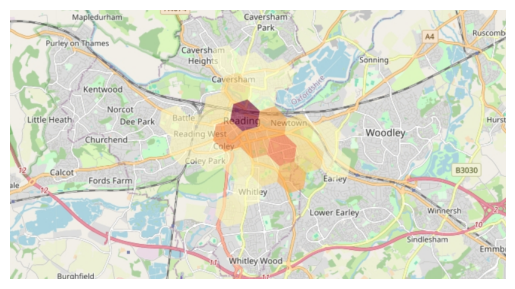

Due to display problems when converting web pages to PDF, the Hexagons results cannot be displayed correctly in the PDF, so a separate picture of the results is shown here.


In [15]:
import matplotlib.image as mpimg

map_file_path = '/data/lab/STA326_Assignment2/result.html'
folium_map.save(map_file_path)

img = mpimg.imread('/data/lab/STA326_Assignment2/result.jpg')
plt.imshow(img)
plt.axis('off')  
plt.show()

print("Due to display problems when converting web pages to PDF, the Hexagons results cannot be displayed correctly in the PDF, so a separate picture of the results is shown here.")